# Car Fuel Consumption

<div style="text-align: right;font-size: 16px;">
    2019/05/29
</div>

### 課題
- どんな要素がガソリンを消費するのかを予測
- SP98,E10のガソリンの種類に応じて消費量を予測

### データ情報
このデータに含まれている各種データ
- distance:車のディスプレイに表示される距離（km）
- consume:消費量（L/100km）
- speed:平均速度（km/h）
- temp_inside:内部温度（℃）
- temp_outside:外部温度（℃）
- specials:乗車中に以下の３つの特別なことがあった場合
- AC:エアコンの利用有無
- rain:雨が降っていた場合
- sun:天候が晴れで車のエンジンをスタートする際に温かく感じたとき
- gas_type:E10,SP98の2種類のいずれかを使用
- refill liters:どのくらいガソリンを給油したのか
- refill gas:どの種類のガソリンを給油したのか

### 実行内容
- 前処理（既存情報より特徴量を2つ生成）
- 特徴選択前後でのLinear Regressionによる差異をホールドアウトで評価して比較
- 特徴量選択結果と前回実施で汎化誤差が最少だったElasticNetを組合わせて評価
- Descision Tree, Random Forest, AdaBoost，Neaural Networkによるモデル評価


## １．データセットの読込と共通利用関数定義

In [164]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

### 共通利用関数定義

In [167]:
def print_score(y, y_pred, is_train=True):
    '''
    評価用関数
    '''
    print('== {} data =='.format('Training' if is_train else 'Test'))
    print('MAE（絶対誤差） = {:.3f}'.format(mean_absolute_error(y, y_pred)))
    print('MSE（二乗誤差） = {:.3f}'.format(mean_squared_error(y, y_pred)))
    print('RMSE（平方根二乗誤差） = {:.3f}'.format(np.sqrt(mean_squared_error(y, y_pred))))

### データの読込

In [147]:
# distance, consume, temp_insideの小数点識別記号が異なるため変更
df_mm = pd.read_csv('measurements.csv', decimal=',')

display(df_mm.head())
df_mm.info()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null float64
consume          388 non-null float64
speed            388 non-null int64
temp_inside      376 non-null float64
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    13 non-null float64
refill gas       13 non-null object
dtypes: float64(4), int64(5), object(3)
memory usage: 36.5+ KB


In [148]:
df_mm.describe(include='all')

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
count,388.000000,388.000000,388.000000,376.000000,388.000000,93,388,388.000000,388.000000,388.000000,13.000000,13
unique,NaN,NaN,NaN,NaN,NaN,12,2,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,rain,SP98,NaN,NaN,NaN,NaN,SP98
freq,NaN,NaN,NaN,NaN,NaN,32,228,NaN,NaN,NaN,NaN,8
mean,19.652835,4.912371,41.927835,21.929521,11.358247,NaN,NaN,0.077320,0.123711,0.082474,37.115385,NaN
std,22.667837,1.033172,13.598524,1.010455,6.991542,NaN,NaN,0.267443,0.329677,0.275441,8.587282,NaN
min,1.300000,3.300000,14.000000,19.000000,-5.000000,NaN,NaN,0.000000,0.000000,0.000000,10.000000,NaN
25%,11.800000,4.300000,32.750000,21.500000,7.000000,NaN,NaN,0.000000,0.000000,0.000000,37.600000,NaN
50%,14.600000,4.700000,40.500000,22.000000,10.000000,NaN,NaN,0.000000,0.000000,0.000000,38.000000,NaN
75%,19.000000,5.300000,50.000000,22.500000,16.000000,NaN,NaN,0.000000,0.000000,0.000000,39.000000,NaN


In [86]:
# 欠損値が含まれている範囲と量を確認
print('----------- 欠損値の有無を確認 -----------')
print(df_mm.isnull().any())
print('-' * 42)
print('--------- 欠損値の個数をカウント ---------')
print(df_mm.isnull().sum())
print('-' * 42)

----------- 欠損値の有無を確認 -----------
distance         False
consume          False
speed            False
temp_inside       True
temp_outside     False
specials          True
gas_type         False
AC               False
rain             False
sun              False
refill liters     True
refill gas        True
dtype: bool
------------------------------------------
--------- 欠損値の個数をカウント ---------
distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64
------------------------------------------


In [87]:
print('-------- unique値の出現頻度を確認 --------')
print(df_mm['gas_type'].value_counts())
print('-' * 44)

-------- unique値の出現頻度を確認 --------
SP98    228
E10     160
Name: gas_type, dtype: int64
--------------------------------------------


## ２．前処理
### データクレンジング
- データ内容上、目的に合致していないと考えられる不要説明変数を削除
- gas_typeをダミー値に変換
- temp_insideの欠損値は少ないため、平均値で補てん
- 既存変数を加工することで利用できそうな新規変数を生成

In [151]:
# データ内容上、不要と推定した以下列を削除
df_mm = df_mm.drop(columns='specials')
df_mm = df_mm.drop(columns='refill liters')
df_mm = df_mm.drop(columns='refill gas')

In [152]:
# gas_typeでの違いを数値的に考慮するため、ダミー値に置換
df_mm['gas_type'] = df_mm['gas_type'].replace({'E10': 1, 'SP98': 0})
print(df_mm.head())

   distance  consume  speed  temp_inside  temp_outside  gas_type  AC  rain  \
0      28.0      5.0     26         21.5            12         1   0     0   
1      12.0      4.2     30         21.5            13         1   0     0   
2      11.2      5.5     38         21.5            15         1   0     0   
3      12.9      3.9     36         21.5            14         1   0     0   
4      18.5      4.5     46         21.5            15         1   0     0   

   sun  
0    0  
1    0  
2    0  
3    0  
4    0  


In [153]:
# temp_insideに欠損値が存在するので、平均値で補てん
print('-------- unique値の出現頻度を確認 --------')
print(df_mm['temp_inside'].value_counts())
print('-' * 44)

temp_inside_mean = df_mm['temp_inside'].mean()
print('平均値 = {:.3f}'.format(temp_inside_mean))

df_mm['temp_inside'] = df_mm['temp_inside'].fillna(temp_inside_mean)

-------- unique値の出現頻度を確認 --------
21.5    133
22.0    102
22.5     59
20.0     25
23.0     13
21.0     13
25.0     12
24.5      7
20.5      4
24.0      3
25.5      2
23.5      2
19.0      1
Name: temp_inside, dtype: int64
--------------------------------------------
平均値 = 21.930


In [154]:
# 車内気温と社外気温の差を新しい変数として追加
df_mm['temp_diff'] = abs(df_mm['temp_outside']- df_mm['temp_inside'])
# 推定乗車時間を新しい変数として追加
df_mm['times'] = np.log(df_mm['distance'] / df_mm['speed'])

In [155]:
df_mm.describe(include='all')

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,temp_diff,times
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.412371,0.077320,0.123711,0.082474,11.109934,-0.979247
std,22.667837,1.033172,13.598524,0.994666,6.991542,0.492897,0.267443,0.329677,0.275441,5.758641,0.560490
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.782158
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000,6.500000,-1.293101
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,0.000000,11.500000,-1.003302
75%,19.000000,5.300000,50.000000,22.500000,16.000000,1.000000,0.000000,0.000000,0.000000,14.625000,-0.657684
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,1.000000,26.000000,0.969831


### データ間の関係性を確認

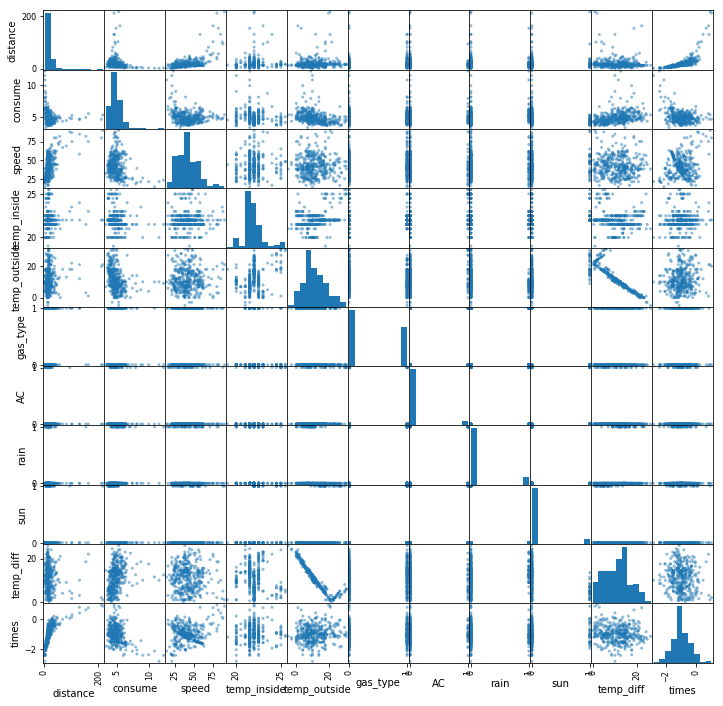

In [156]:
pd.plotting.scatter_matrix(df_mm, figsize=(12,12))
plt.show()

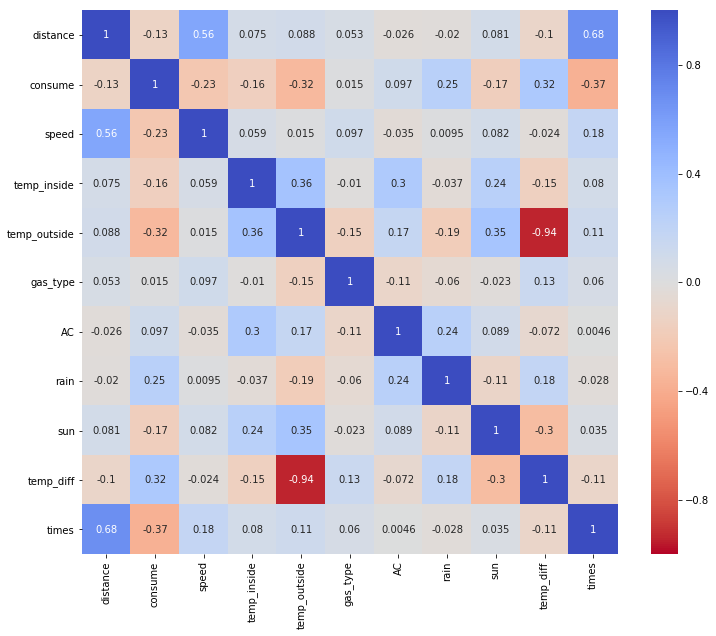

In [157]:
# 相関係数を確認
plt.figure(figsize=(12,10))
sns.heatmap(df_mm.corr(), annot=True, cmap='coolwarm_r', vmin=-1, vmax=1)
plt.show()

### 特徴量操作なしでの評価

In [163]:
# 特徴量操作なしでの実行
y = df_mm['consume'].values
X = df_mm.drop('consume', axis=1)

# ホールドアウトによる評価
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

# 学習データへの予測を実行
y_pred_train = regr.predict(X_train)
print_score(y_train, y_pred_train)

# テストデータへの予測を実行
y_pred_test = regr.predict(X_test)
print_score(y_test, y_pred_test, is_train=False)

== training data ==
MAE（絶対誤差） = 0.556
MSE（二乗誤差） = 0.593
RMSE（平方根二乗誤差） = 0.770
== test data ==
MAE（絶対誤差） = 0.651
MSE（二乗誤差） = 0.719
RMSE（平方根二乗誤差） = 0.848


### フィルタ法による変数の削除

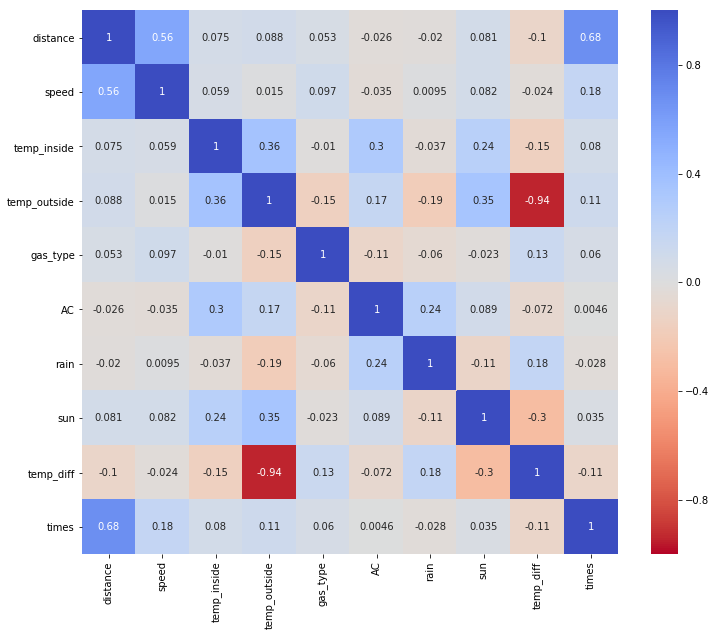

In [96]:
plt.figure(figsize=(12,10))
sns.heatmap(df_mm.drop(['consume'], axis=1).corr(), annot=True, cmap='coolwarm_r', vmin=-1, vmax=1)
plt.show()

- 正負でそれぞれ相関0.5を超える値を示した項目をすべて適用除外して、評価を行う

In [168]:
# フィルタ法による特徴量削減データの評価
# 係数を求める
y_fil = df_mm['consume'].values
X_fil = df_mm[['gas_type', 'AC', 'rain', 'sun', 'times', 'temp_outside']].values

# ホールドアウトによる評価
X_train, X_test, y_train, y_test = train_test_split(X_fil, y_fil, test_size=0.2, random_state=1234)
regr_fil = LinearRegression(fit_intercept=True)
regr_fil.fit(X_train, y_train)

# 学習データへの予測を実行
y_pred_train = regr_fil.predict(X_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
print_score(y_train, y_pred_train)

# テストデータへの予測を実行
y_pred_test = regr_fil.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
print_score(y_test, y_pred_test, is_train=False)

== Training data ==
MAE（絶対誤差） = 0.598
MSE（二乗誤差） = 0.805
RMSE（平方根二乗誤差） = 0.897
== Test data ==
MAE（絶対誤差） = 0.645
MSE（二乗誤差） = 0.718
RMSE（平方根二乗誤差） = 0.847


### ステップワイズ法による評価

In [169]:
estimator = LinearRegression(normalize=False)
rfecv = RFECV(estimator, cv=10, scoring='neg_mean_absolute_error')

In [170]:
train_label = df_mm['consume']
train_data = df_mm.drop('consume', axis=1)

y_step = train_label.values
X_step = train_data.values

# fitで特徴選択を実行
rfecv.fit(X_step, y_step)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_absolute_error',
      step=1, verbose=0)

In [171]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[1 1 1 2 1 1 1 1 1 1]


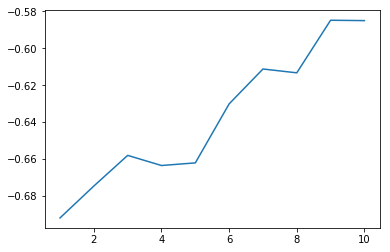

In [172]:
# 特徴数とスコアの変化をプロット
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [174]:
remove_idx = ~rfecv.support_
remove_idx

# 削除してもよい特徴の名前を取得する
remove_feature = train_data.columns[remove_idx]
remove_feature

Index(['temp_outside'], dtype='object')

In [176]:
# ステップワイズ法による特徴量削減時の評価
y_step = df_mm['consume'].values
X_step = df_mm[['gas_type', 'AC', 'rain', 'sun',  'temp_diff', 'temp_inside', 'times']].values

# ホールドアウトによる評価
X_train, X_test, y_train, y_test = train_test_split(X_step, y_step, test_size=0.2, random_state=1234)
regr_step = LinearRegression(fit_intercept=True)
regr_step.fit(X_train, y_train)

# 学習データへの予測を実行
y_pred_train = regr_step.predict(X_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
print_score(y_train, y_pred_train)

# テストデータへの予測を実行
y_pred_test = regr_step.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
print_score(y_test, y_pred_test, is_train=False)

== Training data ==
MAE（絶対誤差） = 0.585
MSE（二乗誤差） = 0.795
RMSE（平方根二乗誤差） = 0.892
== Test data ==
MAE（絶対誤差） = 0.641
MSE（二乗誤差） = 0.714
RMSE（平方根二乗誤差） = 0.845


### LASSOによる特徴選択

In [192]:
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)
sfm = SelectFromModel(estimator, threshold=1e-1)

In [197]:
train_label = df_mm['consume']
train_data = df_mm.drop('consume', axis=1)

y = train_label.values
X = train_data.values

# fitで特徴選択を実行
sfm.fit(X, y)

# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([False, False,  True, False,  True,  True,  True,  True, False,
        True])

In [195]:
removed_idx  = ~sfm.get_support()
remove_feature = train_data.columns[removed_idx]
remove_feature

Index(['distance', 'speed', 'temp_outside', 'temp_diff'], dtype='object')

In [210]:
# 特徴量削減時の評価
y_las = df_mm['consume'].values
X_las = df_mm.drop(columns=['consume', 'distance', 'speed', 'temp_outside', 'temp_diff'], axis=1)

# ホールドアウトによる評価
X_train, X_test, y_train, y_test = train_test_split(X_las, y_las, test_size=0.2, random_state=1234)
regr_las = LinearRegression(fit_intercept=True)
regr_las.fit(X_train, y_train)

# 学習データへの予測を実行
y_pred_train = regr_las.predict(X_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
print_score(y_train, y_pred_train)

# テストデータへの予測を実行
y_pred_test = regr_las.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
print_score(y_test, y_pred_test, is_train=False)

== Training data ==
MAE（絶対誤差） = 0.630
MSE（二乗誤差） = 0.815
RMSE（平方根二乗誤差） = 0.903
== Test data ==
MAE（絶対誤差） = 0.593
MSE（二乗誤差） = 0.857
RMSE（平方根二乗誤差） = 0.926


- 実行結果より、訓練誤差・汎化誤差ともにステップワイズ法で若干の減少は見られたので、以降のアルゴリズムで使用する際はこちらとの比較を実施

### ElasticNet + ステップワイズ法

DAY2までの実施状況からElasticNetを採用した際の汎化誤差が一番小さかったため、
ElasticNet＋ステップワイズ法で確認を行う。

◆ElasticNet実施時のDAY2課題提出時の汎化誤差
- MAE = 0.638

In [214]:
#y_step = df_mm['consume'].values
#X_step = df_mm[['gas_type', 'AC', 'rain', 'sun',  'temp_diff', 'temp_inside', 'times']].values

# ホールドアウトによる評価
X_train, X_test, y_train, y_test = train_test_split(X_step, y_step, test_size=0.2, random_state=1500)
ela_est = make_pipeline(PolynomialFeatures(2), ElasticNet(alpha=1e-2, l1_ratio=1e-1, max_iter=1e4))
ela_est.fit(X_train, y_train)

# 学習データへの予測を実行
y_pred_train = ela_est.predict(X_train)
print_score(y_train, y_pred_train)

# テストデータへの予測を実行
y_pred_test = ela_est.predict(X_test)
print_score(y_test, y_pred_test, is_train=False)

== Training data ==
MAE（絶対誤差） = 0.524
MSE（二乗誤差） = 0.517
RMSE（平方根二乗誤差） = 0.719
== Test data ==
MAE（絶対誤差） = 0.501
MSE（二乗誤差） = 0.563
RMSE（平方根二乗誤差） = 0.751


## Decision Tree、Random Forest、Nearal Network

### Decision Tree

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1500)
dtr = DecisionTreeRegressor(criterion="mse", max_depth=None, min_samples_split=3, min_samples_leaf=3, random_state=1234)
dtr = dtr.fit(X_train, y_train)

# Trainingデータによる評価
y_train_pred = dtr.predict(X_train)
print_score(y_train, y_train_pred)

# Testデータによる評価
y_test_pred = dtr.predict(X_test)
print_score(y_test, y_test_pred)

== Training data ==
MAE（絶対誤差） = 0.251
MSE（二乗誤差） = 0.138
RMSE（平方根二乗誤差） = 0.371
== Training data ==
MAE（絶対誤差） = 0.523
MSE（二乗誤差） = 0.595
RMSE（平方根二乗誤差） = 0.771


In [217]:
# ステップワイズ法にて選択された特徴を使用して比較する
X_train, X_test, y_train, y_test = train_test_split(X_step, y_step, test_size=0.2, random_state=1500)
dtregr = DecisionTreeRegressor(criterion="mse", max_depth=None, min_samples_split=3, min_samples_leaf=3, random_state=1234)
dtregr = dtregr.fit(X_train, y_train)

# Trainingデータによる評価
y_train_pred = dtregr.predict(X_train)
print_score(y_train, y_train_pred)

# Testデータによる評価
y_test_pred = dtregr.predict(X_test)
print_score(y_test, y_test_pred)

== Training data ==
MAE（絶対誤差） = 0.312
MSE（二乗誤差） = 0.189
RMSE（平方根二乗誤差） = 0.435
== Training data ==
MAE（絶対誤差） = 0.597
MSE（二乗誤差） = 0.706
RMSE（平方根二乗誤差） = 0.840


### Random Forest

In [229]:
# Desicision Treeと同様のデータで実行
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1500)
regr = RandomForestRegressor(n_estimators=20, max_depth=4, random_state=1500)
regr.fit(X_train,y_train)

# Trainingデータにおける評価
y_train_pred = regr.predict(X_train)
print_score(y_train, y_train_pred)

# Testデータにおける評価
y_test_pred = regr.predict(X_test)
print_score(y_test, y_test_pred, is_train=False)

== Training data ==
MAE（絶対誤差） = 0.406
MSE（二乗誤差） = 0.263
RMSE（平方根二乗誤差） = 0.513
== Test data ==
MAE（絶対誤差） = 0.538
MSE（二乗誤差） = 0.662
RMSE（平方根二乗誤差） = 0.813


In [228]:
# ホールドアウトによる評価
X_train, X_test, y_train, y_test = train_test_split(X_step, y_step, test_size=0.2, random_state=1500)
regr.fit(X_train,y_train)

# Trainingデータにおける評価
y_train_pred = regr.predict(X_train)
print_score(y_train, y_train_pred)

# Testデータにおける評価
y_test_pred = regr.predict(X_test)
print_score(y_test, y_test_pred, is_train=False)

== Training data ==
MAE（絶対誤差） = 0.449
MSE（二乗誤差） = 0.334
RMSE（平方根二乗誤差） = 0.578
== Test data ==
MAE（絶対誤差） = 0.526
MSE（二乗誤差） = 0.562
RMSE（平方根二乗誤差） = 0.750


### AdaBoost

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1500)
ada_regr = AdaBoostRegressor(DecisionTreeRegressor(
    max_depth=3, min_samples_leaf=2, min_samples_split=2,
    random_state=1234, criterion="mse"),
    n_estimators=10, random_state=10)
ada_regr.fit(X_train, y_train)

# Trainデータにおける評価
y_traine_pred = ada_regr.predict(X_train)
print_score(y_train, y_train_pred)

# Testデータにおける評価
y_test_pred = ada_regr.predict(X_test)
print_score(y_test, y_test_pred)

== Training data ==
MAE（絶対誤差） = 0.406
MSE（二乗誤差） = 0.263
RMSE（平方根二乗誤差） = 0.513
== Training data ==
MAE（絶対誤差） = 0.552
MSE（二乗誤差） = 0.711
RMSE（平方根二乗誤差） = 0.843


In [233]:
X_train, X_test, y_train, y_test = train_test_split(X_step, y_step, test_size=0.2, random_state=1500)
ada_regr = AdaBoostRegressor(DecisionTreeRegressor(
    max_depth=3, min_samples_leaf=2, min_samples_split=2,
    random_state=1234, criterion="mse"),
    n_estimators=10, random_state=10)
ada_regr.fit(X_train, y_train)

# Trainデータにおける評価
y_traine_pred = ada_regr.predict(X_train)
print_score(y_train, y_train_pred)

# Testデータにおける評価
y_test_pred = ada_regr.predict(X_test)
print_score(y_test, y_test_pred)

== Training data ==
MAE（絶対誤差） = 0.406
MSE（二乗誤差） = 0.263
RMSE（平方根二乗誤差） = 0.513
== Training data ==
MAE（絶対誤差） = 0.533
MSE（二乗誤差） = 0.475
RMSE（平方根二乗誤差） = 0.689


### Neaural Network

In [136]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor

nn_regr = Sequential()
nn_regr.add(Dense(10, input_dim=10, activation='relu'))
nn_regr.add(Dense(16, activation='relu'))
nn_regr.add(Dense(1))
nn_regr.compile(loss='mean_squared_error', optimizer='adam')
nn_regr.fit(X_train, y_train, epochs=100, verbose=0)

In [145]:
y_train_pred = nn_regr.predict(X_train)
print_score(y_train, y_train_pred)

y_test_pred = nn_regr.predict(X_test)
print_score(y_test, y_test_pred, is_train=False)

== training data ==
MAE（絶対誤差） = 0.563
MSE（二乗誤差） = 0.578
RMSE（平方根二乗誤差） = 0.760
== test data ==
MAE（絶対誤差） = 0.618
MSE（二乗誤差） = 0.726
RMSE（平方根二乗誤差） = 0.852


### 結果評価
AdaBoostによる実行結果が一番汎化誤差が小さかった。<br>
決定木系のグラフは利用していたPC上で表示ができなかったため、目的変数への結果説明に利用できなかった。

### 考察など
DAY2までの実施結果とステップワイズ法で選択された特徴をもとに考えた場合、乗車時間とエアコンの使用有無、天候が燃費に影響を与えている要素だと推測できる。ガソリンの差による影響は殆ど考えられず、こういった要素とエンジン性能の是非が燃費を左右していると考える。